In [1]:
### Run MOFA Model on the data

#############################################
# Prerequisites - Load Libraries

In [2]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../Global_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/jove_r//lib/R/library"


‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.4; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ───────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────

In [3]:
source('MS1_Functions.r')

In [4]:
source('MS2_Plot_Config.r')

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


###############################################
# Preqrequisites Configurations & Parameters

In [5]:
### Load configurations file
global_configs = read.csv('configurations/Global_Configs.csv', sep = ',')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'configurations/Global_Configs.csv'”


In [6]:
head(global_configs,2)

,parameter,parameter.1,value
,<chr>,<chr>,<chr>
1,data_path,data_path,../results/data/input_data/
2,result_path,result_path,../results/data/results/


In [7]:
data_path = global_configs$value[global_configs$parameter == 'data_path']

In [8]:
data_path

[1] "../results/data/input_data/"

In [9]:
result_path = global_configs$value[global_configs$parameter == 'result_path']

In [10]:
result_path

[1] "../results/data/results/"

In [11]:
## MOFA Model Configurations

In [12]:
mofa_configs = read.csv( 'configurations/03_MOFA_Configs.csv', sep = ',')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'configurations/03_MOFA_Configs.csv'”


In [13]:
head(mofa_configs,2)

,configuration_name,mofa_result_name,amount_of_factors,weighting_of_views,scale_views
,<chr>,<chr>,<int>,<lgl>,<lgl>
1,config1,config1,20,FALSE,TRUE


# Load Data 

## Prepared combined data

In [14]:
input_data = list()

In [15]:
for(i in 1:nrow(mofa_configs)){
    path = paste0(result_path, '/02_results/02_Combined_Data_', mofa_configs$configuration_name[i] ,'_INTEGRATED.csv')
    data_long = read.csv(path)
    data_long$X = NULL
    print(path)
    print(file.info(path)$mtime)
    input_data[[i]]= data_long
    }

[1] "../results/data/results//02_results/02_Combined_Data_config1_INTEGRATED.csv"
[1] "2023-12-19 23:36:55 CET"


In [16]:
length(unique(input_data[[1]]$variable))

[1] 9625

In [17]:
unique(input_data[[1]]$type)

[1] "B.cell"     "CD14.Mono"  "CD16.Mono"  "CD4.CTL"    "CD4.Naive" 
 [6] "CD4.TCM"    "CD4.TEM"    "CD8.Naive"  "CD8.TEM"    "cDC2"      
[11] "clinical"   "cytokine"   "gdT"        "neutrophil" "NK"        
[16] "proteomic"  "Treg"

In [18]:
length(unique(input_data[[1]]$sample_id))

[1] 128

# Train MOFA Model

## Prepare data list

In [19]:
### Adjust single-cell types to correspond to cell-types

In [20]:
head(input_data[[1]],2)

,sample_id,variable,value,type,gene
,<chr>,<chr>,<dbl>,<chr>,<chr>
1,k10,B.cell__ACTB,0.4307273,B.cell,ACTB
2,k11,B.cell__ACTB,-0.7009514,B.cell,ACTB


In [21]:
### Prepare data list for MOFA

In [22]:
input_data_list = list()

In [23]:
data_list = list()

In [24]:
input_data_list = lapply(input_data, function(x){

    for(i in unique(x$type)){
        samples = unique(x$sample_id) # necessary to have all samples in all dimensions
        data = x[x$type == i, ]

        data$type = NULL
        data$cell_type = NULL

        data = data %>% dcast(variable ~ sample_id, value  = "value")
        rownames(data) = data$variable
        colnames(data) = str_replace(colnames(data), 'value\\.', '')
        data$variable = NULL

        data[setdiff( samples, names(data))] = NA  # use all samples

        data = data[,order(colnames(data))]
        data = data[,colnames(data) %in% samples]

        data_list[[i]] = as.matrix(data)
        }
    
    return(data_list)
    })

In [25]:
head(input_data_list[[1]][[1]],2)

,k1,k10,k11,k12,k13,k14,k15,k16,k17,k18,⋯,m7.2,m7.3,m7.4,m8.1,m8.2,m8.3,m8.4,m9.1,m9.2,m9.3
B.cell__ACTB,NA,0.4307273,-0.7009514,0.1151410,-0.2858409,0.6102946,0.3186394,-0.7977768,-0.09413741,-0.09413741,⋯,1.4696127,1.469613,-0.09413741,-1.469613,-1.001331,0.984235,-0.4422154,0.3186394,0.4307273,1.09162
B.cell__ACTG1,NA,1.2815516,-0.2533471,0.0417893,-0.6614351,-1.0728613,0.2858409,-0.4079187,0.40791874,-1.13033917,⋯,0.6876604,0.167894,-0.90273479,-1.605730,-0.512454,-1.731664,-1.9599640,-0.7143674,0.8717710,1.21334


In [26]:
#str(input_data_list)

## Create MOFA object

In [27]:
names(input_data_list[[1]])

[1] "B.cell"     "CD14.Mono"  "CD16.Mono"  "CD4.CTL"    "CD4.Naive" 
 [6] "CD4.TCM"    "CD4.TEM"    "CD8.Naive"  "CD8.TEM"    "cDC2"      
[11] "clinical"   "cytokine"   "gdT"        "neutrophil" "NK"        
[16] "proteomic"  "Treg"

In [28]:
mofa_object = lapply(input_data_list, function(x){
    MOFAobject = create_mofa(x)
    }
                     )

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




In [29]:
### Plot Data Overview

In [30]:
# Specific Text Descriptions:
xlabel = xlab('Samples') 
ylabel = ylab('View')

In [31]:
# Sizes of the plot
width_par = 5
height_par =5

In [32]:
options(repr.plot.width=30, repr.plot.height=10)

mofa_overview = lapply(mofa_object, function(x){
    mofa_overview = plot_data_overview(x)
    mofa_overview = mofa_overview + plot_config + theme(axis.text.y = element_text(hjust = 0, vjust = 0.5)) +
                xlabel + ylabel + theme(axis.text.x = element_blank())
    })

In [33]:
#mofa_overview[[1]]

In [34]:
# Extract data -type colors
type_colors = list()
for(i in 1:length(mofa_overview)){
    color_extraction =  ggplot_build(mofa_overview[[i]])
    type_colors[[i]] = unique(color_extraction$data[[1]]["fill"][,1])
    type_colors[[i]] = type_colors[[i]][!type_colors[[i]] == 'grey']
    }
    

In [35]:
type_colors

[[1]]
 [1] "#FF7F50" "#D95F02" "#377EB8" "#E6AB02" "#31A354" "#7570B3" "#E7298A"
 [8] "#66A61E" "#A6761D" "#666666" "#E41A1C" "#4DAF4A" "#984EA3" "#FF7F00"
[15] "#FFFF33" "#A65628" "#F781BF"

In [36]:
figure_name = "FIG03_Overview_MOFA_Input_"

In [37]:

for(i in 1:length(mofa_overview)){
    pdf(paste0('figures/03_figures/', figure_name, mofa_configs$mofa_result[i],  '.pdf'), width =width_par, height =height_par)
    print(mofa_overview[[i]] )
    dev.off()
    }

## Set MOFA Training Options and run the Model Training

In [38]:
model_result = list()

In [39]:
for(i in 1:length(mofa_object)){
    
    ## Set other parameters of MOFA Model
    mefisto_opts = get_default_mefisto_options(mofa_object[[i]])
    
    data_opts = get_default_data_options(mofa_object[[i]])
    data_opts$scale_views = mofa_configs$scale_views[i] # decide whether to scale the data
    print(data_opts)
    
    model_opts = get_default_model_options(mofa_object[[i]])
    model_opts$num_factors = mofa_configs$amount_of_factors[i] # define number of factors
    print(model_opts)
    
    train_opts  = get_default_training_options(mofa_object[[i]])
    train_opts$maxiter = 50000
    train_opts$verbose = TRUE
    train_opts$seed = 42
    train_opts$weight_views = mofa_configs$weighting_of_views[i]
    print(train_opts)
    
    ## Build and train the model
    MOFAobject = prepare_mofa(
      object = mofa_object[[i]],
      data_options = data_opts,
      model_options = model_opts,
      mefisto_options = mefisto_opts,
      training_options = train_opts #,
      #stochastic_options = stoch_options
    )
    
    model_name = paste0("03_MOFA_MODEL_", mofa_configs$mofa_result[i], '.hdf5')
    outfile = file.path( paste0(result_path, '/03_results/',  model_name) )
    print(outfile)
    MOFAobject.trained = run_mofa(MOFAobject, outfile, use_basilisk = FALSE)
    

    model_result[[i]] = MOFAobject.trained
    
    }
    

$scale_views
[1] TRUE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] TRUE

$views
 [1] "B.cell"     "CD14.Mono"  "CD16.Mono"  "CD4.CTL"    "CD4.Naive" 
 [6] "CD4.TCM"    "CD4.TEM"    "CD8.Naive"  "CD8.TEM"    "cDC2"      
[11] "clinical"   "cytokine"   "gdT"        "neutrophil" "NK"        
[16] "proteomic"  "Treg"      

$groups
[1] "group1"

$likelihoods
    B.cell  CD14.Mono  CD16.Mono    CD4.CTL  CD4.Naive    CD4.TCM    CD4.TEM 
"gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" 
 CD8.Naive    CD8.TEM       cDC2   clinical   cytokine        gdT neutrophil 
"gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" 
        NK  proteomic       Treg 
"gaussian" "gaussian" "gaussian" 

$num_factors
[1] 20

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] FALSE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

$maxiter
[1] 50000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] TRUE

$startELBO


Warning message in prepare_mofa(object = mofa_object[[i]], data_options = data_opts, :
“Some view(s) have less than 15 features, MOFA will have little power to to learn meaningful factors for these view(s)....”
Checking data options...

Checking training options...

Checking model options...



[1] "../results/data/results//03_results/03_MOFA_MODEL_config1.hdf5"



Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'


Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 5, 9, 10, 20 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


In [40]:
#str(model_result)

# Extract and prepare data for plots

## Extract Variance decomposition

In [41]:
# Total variance explained per view and factor

In [42]:
model_result[[1]]@cache[["variance_explained"]]$r2_total  # per view

$group1
    B.cell  CD14.Mono  CD16.Mono    CD4.CTL  CD4.Naive    CD4.TCM    CD4.TEM 
  36.95212   59.56702   36.56451   38.80110   28.77563   60.33708   33.99470 
 CD8.Naive    CD8.TEM       cDC2   clinical   cytokine        gdT neutrophil 
  20.91215   39.65517   27.74364   62.35304   22.31230   49.89122   16.01949 
        NK  proteomic       Treg 
  42.12312   13.74467   31.42046

In [43]:
rowMeans(model_result[[1]]@cache$variance_explained$r2_per_factor[[1]]) # per factor

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7   Factor8 
5.6383473 4.9891847 3.3329830 2.5853897 2.4858664 2.0326800 1.6768385 1.5536687 
  Factor9  Factor10  Factor11  Factor12  Factor13  Factor14  Factor15  Factor16 
1.4920655 1.4327417 1.4260092 1.3838789 1.2031376 1.0185669 0.9383826 0.9368875 
 Factor17  Factor18  Factor19  Factor20 
0.8269675 0.7940429 0.7826128 0.7687513

In [44]:
# Mean total variance explained

In [45]:
mean(model_result[[1]]@cache$variance_explained$r2_total[[1]])

[1] 36.53926

In [46]:
# Save the explained variance

In [47]:
for(i in 1:length(model_result)){
    write.csv(model_result[[i]]@cache$variance_explained$r2_per_factor[[1]], paste0(result_path, '/03_results/03_MOFA_Variance_Decomposition_',mofa_configs$mofa_result[i], '.csv'))
    }
    

## Extract factor and weight data

In [48]:
#### Extract factors 

In [49]:
for(i in 1:length(model_result)){
    factors = get_factors(model_result[[i]], factors = "all")
    factors = factors$group1
    head(factors,2)
    
    factors = as.data.frame(factors)
    factors$sample_id = rownames(factors)
    
    # Save as csv
    write.csv(factors, paste0(result_path, '/03_results/03_Factor_Data_' , mofa_configs$mofa_result[i],  '.csv'), row.names = FALSE)
    }

In [50]:
### Extract Weight data

In [51]:
for(j in 1:length(model_result)){
    weights = get_weights(model_result[[j]], views = "all", factors = "all")
    weight_data = data.frame()
    
    for (i in names(weights)){
        data = data.frame(weights[[i]])
        data$type = i
        weight_data = rbind(weight_data,data)
        }
    weight_data$variable_name = rownames(weight_data)
    
    # Save as csv
    write.csv(weight_data, paste0(result_path, '/03_results/03_Weight_Data_' ,mofa_configs$mofa_result[j], '.csv'), row.names = FALSE)
    }
    

# Diagnostic Result Plots

## Plot explained variance overview

In [52]:
## Get data

In [53]:
#head(explained_variance[[1]])

In [54]:
explained_variance = lapply(model_result, function(x) {
    data = x@cache$variance_explained$r2_per_factor[[1]]
    data = melt(data)
    
    total_variance = data.frame( view = rownames(x@cache[["variance_explained"]]$r2_total$group1,2),
                             total_variance = x@cache[["variance_explained"]]$r2_total$group1)
    data = merge(data, total_variance, by.x = 'Var2', by.y = 'view')
    data$Var2 = as.character(data$Var2)
    data$Var2 = factor(data$Var2, levels = sort(unique(data$Var2)))
    data = data[order(data$Var2),]
    }
                            )

In [55]:
#### Plot complete explained variance

In [56]:
var_decomp = lapply(explained_variance, function(x){
    ggplot() + 
        scale_fill_gradient(low="white", high="black") + 
        xlabel + 
        ylabel +
        plot_config + theme(axis.text.x = element_text(angle = 90), legend.position = 'right')+ 
        geom_tile(data = x, mapping = aes(Var1,  Var2, fill= value))
    })

In [57]:
#var_decomp[[1]]

In [58]:
### Combine with total variance barplot per dimension

In [59]:
# Specific Text Descriptions:
xlabel = xlab('View') 
ylabel = ylab('Explained Variance')

In [60]:
comp_variance = lapply(explained_variance, function(x){
    data = x
    plot_complete = unique(data[,c('Var2', 'total_variance')])
    comp_variance = ggplot(plot_complete, aes(x=Var2, y = total_variance, fill = Var2)) + 
                geom_bar(stat="identity") + coord_flip() + 
                xlabel + 
                ylabel +
                plot_config + scale_fill_manual(values = unlist(type_colors))  ## currently uses same coloring as MOFA oveview
    })

In [61]:
#comp_variance[[1]]

In [62]:
### Combine both visualization

In [63]:
figure_name = "FIG03_Overview_Variance_Decomposition"

In [64]:
# Sizes of the plot
width_par = 8.07
height_par = 4  # 2.8

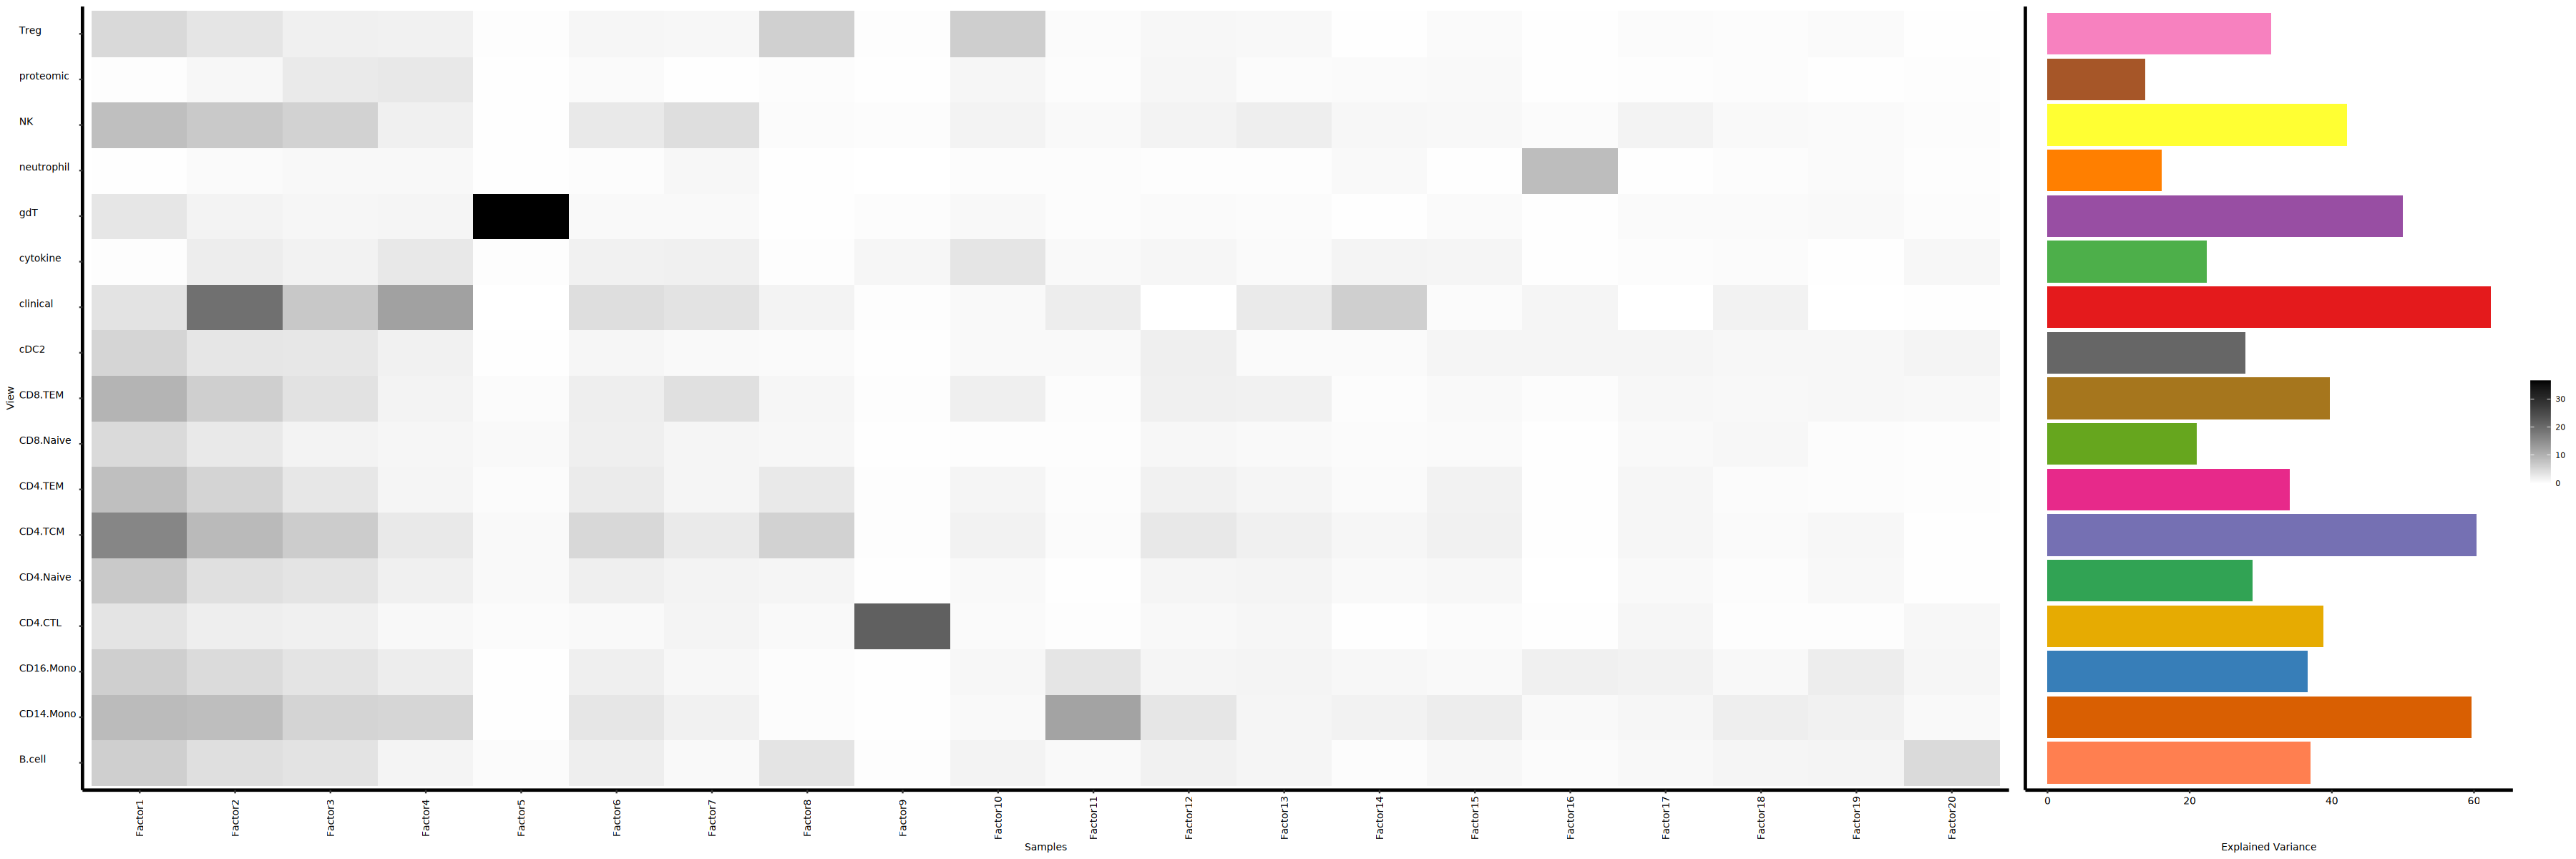

In [65]:
for(i in 1:length(explained_variance)){
    legend = get_legend(var_decomp[[i]])
    
    combination1 = ggarrange(var_decomp[[i]] + theme(legend.position = 'none'),
                     comp_variance[[i]] + theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank(), legend.position = 'none' ), 
                         align = 'h', nrow=1, widths = c(4,1))
    # Annotate Figure
    combination1_ann = annotate_figure(
      combination1,
      right = legend
    )
    
    pdf(paste0('figures/03_figures/', figure_name,  mofa_configs$mofa_result[i],  '.pdf'), width =width_par, height =height_par)
    print(combination1_ann)
    dev.off()
    print(combination1_ann)
    
    }
    

In [66]:
## Save view colors for further usage

In [67]:
write.csv(data.frame(color_code = unlist(type_colors)),
          paste0('configurations/03_Type_Color_Codes.csv'))